In [1]:
from matplotlib import pyplot as plt
from itertools import product
# import seaborn as sns
import pandas as pd
import os.path as op
import argparse
import re
import numpy as np
import matplotlib.pyplot as plt
import mne
import seaborn as sns
from scipy import signal, stats
from scipy.fft import fftshift
from bids import BIDSLayout
from statsmodels.stats.anova import AnovaRM

from util.io.ffr import *

#### Compute ERP peaks

In [2]:
# # Read data
# evokeds = pd.read_csv('evokeds.csv')
# evokeds['uV'] = evokeds['uV'] * 1000000
# evokeds = evokeds[evokeds.chan == 'Cz']

# all_peaks = pd.DataFrame()
# tones = [1, 2, 3]
# predictability = [True, False]
# segments = [("max", 80, 130), ("min", 100, 180), ("max", 150, 280), ("min", 250, 450), ("inflection", 430, 430)]

# for tone in tones:
#     for target in tones:
#         for predictable in predictability:
#             for segment in segments:
#                 peak_type = segment[0]
#                 start = segment[1]
#                 end = segment[2]

#                 # Segment the data
#                 cond_evokeds = evokeds[(evokeds.tone == tone) &
#                             (evokeds.target == target) &
#                             (evokeds.predictable == predictable)]

#                 # Take a time slice
#                 seg = cond_evokeds[cond_evokeds.msec >= start]
#                 seg = seg[seg.msec <= end]
                
#                 # Calculate the max for each subject
#                 if peak_type == "max":
#                     peaks = seg.groupby(['sub'], as_index = False)['uV'].max()
#                 elif peak_type == "min":
#                     peaks = seg.groupby(['sub'], as_index = False)['uV'].min()
#                 elif peak_type == "inflection":
#                     peaks = seg[seg.msec == 430]
#                     peaks = peaks.drop(columns = ['chan', 'accuracy', 'msec'])

#                 # Create a data frame
#                 peaks['tone'] = tone
#                 peaks['target'] = target
#                 peaks['predictable'] = predictable
#                 peaks['peak_type'] = peak_type
#                 peaks['start'] = start
#                 peaks['end'] = end

#                 # Bind to data frame
#                 all_peaks = pd.concat([all_peaks, peaks])
#                 all_peaks = all_peaks.reset_index(drop = True)
#     #             break
#     #         break
#     #     break
#     # break
# all_peaks.to_csv('erp_peaks.csv', index = False)
erp_peaks = pd.read_csv('erp_peaks.csv')
erp_peaks

,sub,uV,tone,target,predictable,peak_type,start,end
0,2,1.655088,1,1,True,max,80,130
1,3,0.519427,1,1,True,max,80,130
2,4,1.499844,1,1,True,max,80,130
3,5,1.498788,1,1,True,max,80,130
4,6,0.776012,1,1,True,max,80,130
...,...,...,...,...,...,...,...,...
3550,37,-0.378191,3,3,False,inflection,430,430
3551,38,-0.408262,3,3,False,inflection,430,430
3552,39,-0.297021,3,3,False,inflection,430,430
3553,40,-0.103029,3,3,False,inflection,430,430


#### Compute FFR spectrum peaks

In [3]:
# spectrums = pd.read_csv('spectrums.csv', sep = '\t')
# all_stims_power = pd.DataFrame()
# stim_freqs = [110, 150, 210]

# for stim_freq in stim_freqs:    
#     print(f'{stim_freq} Hz stimulus')

#     # select Fourier frequency nearest to stimulus frequency 
#     idx = np.abs(spectrums.frequency - stim_freq).argmin()
#     hz = spectrums.frequency[idx]
#     power_f0 = spectrums[spectrums.frequency == hz]
#     power_f0 = power_f0[power_f0.tone == stim_freq]

#     # append to df
#     all_stims_power = pd.concat([all_stims_power, power_f0])
#     all_stims_power = all_stims_power.reset_index(drop = True)
# all_stims_power.to_csv('ffr_peaks.csv', index = False)
ffr_peaks = pd.read_csv('ffr_peaks.csv')
ffr_peaks

,subject,predictable,target,tone,frequency,dB
0,2,True,110,110,109.89011,-1.550990
1,2,True,150,110,109.89011,1.220978
2,2,True,210,110,109.89011,-1.265297
3,2,False,110,110,109.89011,-1.976504
4,2,False,150,110,109.89011,1.783181
...,...,...,...,...,...,...
652,41,True,150,210,209.79021,3.602979
653,41,True,210,210,209.79021,1.987186
654,41,False,110,210,209.79021,4.831819
655,41,False,150,210,209.79021,1.524062


In [75]:
np.unique(ffr_peaks['subject'])

array([ 2,  3,  5,  6,  7,  9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41])

#### Combine into one dataframe

In [4]:
# # Combine into one dataframe
# print(len(np.unique(ffr_peaks.subject)))
# print(len(np.unique(erp_peaks['sub'])))
# all_peaks = pd.DataFrame()

# for sub in np.unique(ffr_peaks.subject):
#     # Subset data
#     sub_ffr_peaks = ffr_peaks[ffr_peaks.subject == sub]
#     sub_erp_peaks = erp_peaks[erp_peaks['sub'] == sub]

#     # Match columns
#     sub_erp_peaks = sub_erp_peaks.rename(columns = {'sub': 'subject'})
#     sub_erp_peaks['tone'] = sub_erp_peaks['tone'].replace({1: 110, 2: 150, 3: 210})
#     sub_erp_peaks['target'] = sub_erp_peaks['target'].replace({1: 110, 2: 150, 3: 210})

#     # Merge dfs
#     sub_peaks = sub_erp_peaks.merge(sub_ffr_peaks, left_on = ["subject", "predictable", "tone", "target"], right_on = ["subject", "predictable", "tone", "target"])
#     all_peaks = pd.concat([all_peaks, sub_peaks])
#     all_peaks = all_peaks.reset_index(drop = True)

# all_peaks.to_csv('all_peaks.csv', index = False)
all_peaks = pd.read_csv('all_peaks.csv')
all_peaks

,subject,uV,tone,target,predictable,peak_type,start,end,frequency,dB
0,2,1.655088,110,110,True,max,80,130,109.89011,-1.550990
1,2,-0.254941,110,110,True,min,100,180,109.89011,-1.550990
2,2,1.262410,110,110,True,max,150,280,109.89011,-1.550990
3,2,-1.666572,110,110,True,min,250,450,109.89011,-1.550990
4,2,-1.422102,110,110,True,inflection,430,430,109.89011,-1.550990
...,...,...,...,...,...,...,...,...,...,...
3280,41,1.188225,210,210,False,max,80,130,209.79021,-1.925194
3281,41,0.230461,210,210,False,min,100,180,209.79021,-1.925194
3282,41,0.890719,210,210,False,max,150,280,209.79021,-1.925194
3283,41,-0.691765,210,210,False,min,250,450,209.79021,-1.925194


In [5]:
# Drop subjects with fewer than 80% trials
BADS = [2, 3, 6, 33, 37]
for bad in BADS:
    all_peaks = all_peaks[all_peaks['subject'] != bad]
np.unique(all_peaks['subject'])

array([ 5,  7,  9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 39, 40, 41])

## Regressions

#### 110 Hz tone

-0.07287908240851224 0.4934502019595497 -0.4158708835822473 0.022273478465380598 0.03011838065668019


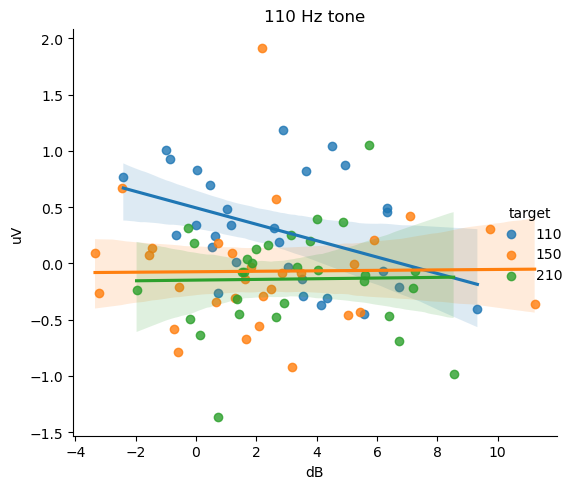

In [26]:
peaks_110 = all_peaks[all_peaks.tone == 110]

# peak = peaks_110[peaks_110.start == 80]
# sns.lmplot(data = peak, x = "dB", y = "uV", hue = "target")
# ax = plt.gca()
# ax.set_title("Max at 80-130 ms")

# peak = peaks_110[peaks_110.start == 100]
# sns.lmplot(data = peak, x = "dB", y = "uV", hue = "target")
# ax = plt.gca()
# ax.set_title("Min at 100-280 ms")

# peak = peaks_110[peaks_110.start == 150]
# sns.lmplot(data = peak, x = "dB", y = "uV", hue = "target")
# ax = plt.gca()
# ax.set_title("Max at 150-280 ms")

# peak = peaks_110[peaks_110.start == 250]
# sns.lmplot(data = peak, x = "dB", y = "uV", hue = "target")
# ax = plt.gca()
# ax.set_title("Min at 250-450 ms")

peak = peaks_110[peaks_110.start == 430]
uV = peak.groupby(['subject', 'target'], as_index=False)['uV'].mean()
dB = peak.groupby(['subject', 'target'], as_index=False)['dB'].mean()
df = uV
df['dB'] = dB.dB

# Plot
sns.lmplot(data = df, x = "dB", y = "uV", hue = "target")
ax = plt.gca()
ax.set_title("110 Hz tone")
plt.tight_layout()
plt.savefig('../figs/ERP-FFR-tone-1.png')

# Regression
df = df[df.target == 110]
slope, intercept, r_value, p_value, std_err = stats.linregress(df.dB, df.uV)
print(slope, intercept, r_value, p_value, std_err)

#### 150 Hz tone

-0.05190339960632509 0.3620956840126054 -0.3889033504336955 0.03366829404760457 0.023236251491017292


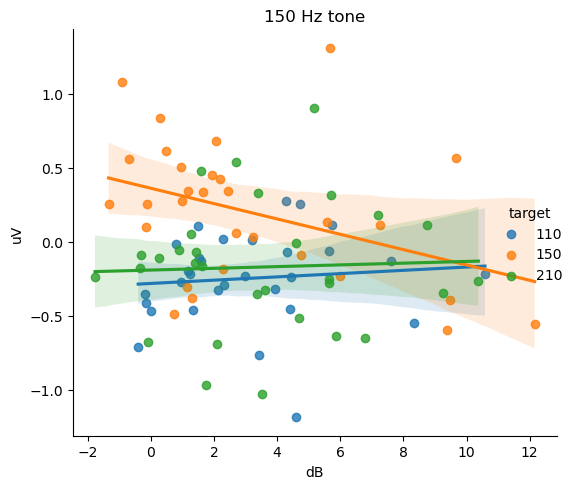

In [35]:
peaks_150 = all_peaks[all_peaks.tone == 150]

# peak = peaks_150[peaks_150.start == 80]
# sns.lmplot(data = peak, x = "dB", y = "uV", hue = "target")
# ax = plt.gca()
# ax.set_title("Max at 80-130 ms")

# peak = peaks_150[peaks_150.start == 100]
# sns.lmplot(data = peak, x = "dB", y = "uV", hue = "target")
# ax = plt.gca()
# ax.set_title("Min at 100-280 ms")

# peak = peaks_150[peaks_150.start == 150]
# sns.lmplot(data = peak, x = "dB", y = "uV", hue = "target")
# ax = plt.gca()
# ax.set_title("Max at 150-280 ms")

# peak = peaks_150[peaks_150.start == 250]
# sns.lmplot(data = peak, x = "dB", y = "uV", hue = "target")
# ax = plt.gca()
# ax.set_title("Min at 250-450 ms")

peak = peaks_150[peaks_150.start == 430]
uV = peak.groupby(['subject', 'target'], as_index=False)['uV'].mean()
dB = peak.groupby(['subject', 'target'], as_index=False)['dB'].mean()
df = uV
df['dB'] = dB.dB

# Plot
sns.lmplot(data = df, x = "dB", y = "uV", hue = "target")
ax = plt.gca()
ax.set_title("150 Hz tone")
plt.tight_layout()
plt.savefig('../figs/ERP-FFR-tone-2.png')

# Regression
df = df[df.target == 150]
slope, intercept, r_value, p_value, std_err = stats.linregress(df.dB, df.uV)
print(slope, intercept, r_value, p_value, std_err)

#### 210 Hz tone

-0.03593153463890169 0.19268882307825447 -0.2116275843286113 0.25309075651989804 0.030814475436103925


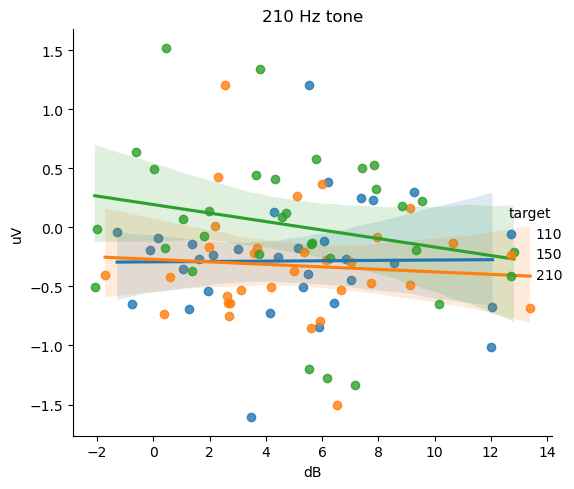

In [38]:
peaks_210 = all_peaks[all_peaks.tone == 210]

# peak = peaks_210[peaks_210.start == 80]
# sns.lmplot(data = peak, x = "dB", y = "uV", hue = "target")
# ax = plt.gca()
# ax.set_title("Max at 80-130 ms")

# peak = peaks_210[peaks_210.start == 100]
# sns.lmplot(data = peak, x = "dB", y = "uV", hue = "target")
# ax = plt.gca()
# ax.set_title("Min at 100-280 ms")

# peak = peaks_210[peaks_210.start == 150]
# sns.lmplot(data = peak, x = "dB", y = "uV", hue = "target")
# ax = plt.gca()
# ax.set_title("Max at 150-280 ms")

# peak = peaks_210[peaks_210.start == 250]
# sns.lmplot(data = peak, x = "dB", y = "uV", hue = "target")
# ax = plt.gca()
# ax.set_title("Min at 250-450 ms")

peak = peaks_210[peaks_210.start == 430]
uV = peak.groupby(['subject', 'target'], as_index=False)['uV'].mean()
dB = peak.groupby(['subject', 'target'], as_index=False)['dB'].mean()
df = uV
df['dB'] = dB.dB

# Plot
sns.lmplot(data = df, x = "dB", y = "uV", hue = "target")
ax = plt.gca()
ax.set_title("210 Hz tone")
plt.tight_layout()
plt.savefig('../figs/ERP-FFR-tone-3.png')

# Regression
df = df[df.target == 210]
slope, intercept, r_value, p_value, std_err = stats.linregress(df.dB, df.uV)
print(slope, intercept, r_value, p_value, std_err)

#### Interactions with task performance

In [64]:
accuracies = pd.read_csv('accuracies.csv')
accuracies = accuracies.rename(columns = {'sub_num': 'subject'})
all_peaks = pd.read_csv('all_peaks.csv')
all_peaks = all_peaks.merge(accuracies, left_on = ['subject'], right_on = ['subject'])

In [40]:
# Drop subjects with fewer than 80% trials
BADS = [2, 3, 6, 33, 37]
for bad in BADS:
    all_peaks = all_peaks[all_peaks['subject'] != bad]
np.unique(all_peaks['subject'])

array([ 5,  7,  9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 39, 40, 41])

In [80]:
intended_subs = set(range(2,42))
ffr_subs = set(ffr_peaks['subject'])
print(intended_subs - ffr_subs)
erp_subs = set(erp_peaks['sub'])
print(intended_subs - erp_subs)
accuracies_subs = set(accuracies['subject'])
print(intended_subs - accuracies_subs)

{8, 10, 4}
set()
set()


In [62]:
tmp = all_peaks[(all_peaks.peak_type == 'inflection') & (all_peaks.tone == 110) & (all_peaks.target == 110) & (all_peaks.predictable == True)]
tmp

,subject,uV,tone,target,predictable,peak_type,start,end,frequency,dB,accuracy,accuracy_group
184,5,-0.431547,110,110,True,inflection,430,430,109.89011,3.346238,0.973030,high
364,7,1.282676,110,110,True,inflection,430,430,109.89011,-1.970147,0.885129,low
454,9,-0.898396,110,110,True,inflection,430,430,109.89011,-3.668071,0.900606,low
544,11,1.639975,110,110,True,inflection,430,430,109.89011,-4.879687,0.925566,low
634,12,0.256588,110,110,True,inflection,430,430,109.89011,-1.973311,0.969187,high
724,13,-0.304690,110,110,True,inflection,430,430,109.89011,-0.240360,0.914903,low
814,14,0.325989,110,110,True,inflection,430,430,109.89011,1.892453,0.936412,high
904,15,0.336876,110,110,True,inflection,430,430,109.89011,6.348472,0.920533,low
994,16,0.144105,110,110,True,inflection,430,430,109.89011,-0.327894,0.940200,high
1084,17,0.196693,110,110,True,inflection,430,430,109.89011,2.444838,0.953808,high


-0.067143424030532 0.34119724270920665 -0.4469249863810197 0.08263996618283262 0.03591863787517678


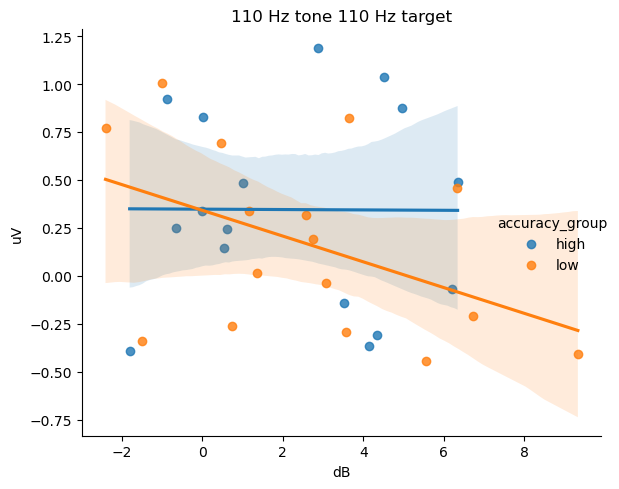

In [53]:

peak = all_peaks[(all_peaks.tone == 110) & (all_peaks.target == 110) & (all_peaks.start == 430)]
uV = peak.groupby(['subject', 'target', 'accuracy_group'], as_index=False)['uV'].mean()
dB = peak.groupby(['subject', 'target', 'accuracy_group'], as_index=False)['dB'].mean()
df = uV
df['dB'] = dB.dB

# Plot
sns.lmplot(data = df, x = "dB", y = "uV", hue = "accuracy_group")
ax = plt.gca()
ax.set_title("110 Hz tone 110 Hz target")
plt.tight_layout()
# plt.savefig('../figs/ERP-FFR-tone-1-by-accuracy.png')

# Regression
df_low = df[df.accuracy_group == 'low']
slope, intercept, r_value, p_value, std_err = stats.linregress(df_low.dB, df_low.uV)
print(slope, intercept, r_value, p_value, std_err)

In [ ]:
peak = all_peaks[(all_peaks.tone == 110) & (all_peaks.target == 110) & (all_peaks.start == 430)]
sns.lmplot(data = peak, x = "dB", y = "uV", hue = "accuracy_group")
ax = plt.gca()
ax.set_title("110 Hz tone 110 Hz target")
plt.tight_layout()
plt.savefig('../figs/ERP-FFR-tone-1-by-accuracy.png')

# x = peak.dB[(peak.tone == 210) & (peak.target == 210)]
# y = peak.uV[(peak.tone == 210) & (peak.target == 210)]
# slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
# print(slope, intercept, r_value, p_value, std_err)

In [ ]:
peak = all_peaks[(all_peaks.tone == 150) & (all_peaks.tone == 150) & (all_peaks.start == 430)]
sns.lmplot(data = peak, x = "dB", y = "uV", hue = "accuracy_group")
ax = plt.gca()
ax.set_title("150 Hz tone 150 Hz target")
plt.tight_layout()
plt.savefig('../figs/ERP-FFR-tone-2-by-accuracy.png')

In [ ]:
peak = all_peaks[(all_peaks.tone == 210) & (all_peaks.tone == 210) & (all_peaks.start == 430)]
sns.lmplot(data = peak, x = "dB", y = "uV", hue = "accuracy_group")
ax = plt.gca()
ax.set_title("210 Hz tone 210 Hz target")
plt.tight_layout()
plt.savefig('../figs/ERP-FFR-tone-3-by-accuracy.png')

In [ ]:
# tmp = sub_erp_peaks.merge(sub_ffr_peaks, how = "left", left_on = ["subject", "tone", "target", "predictable"], right_on = ["subject", "tone", "target", "predictable"])
# tmp
pd.concat([sub_erp_peaks, sub_ffr_peaks], axis = 0)

In [ ]:
tmp = sub_erp_peaks.merge(sub_ffr_peaks, left_on = ["subject", "predictable", "tone", "target"], right_on = ["subject", "predictable", "tone", "target"])
tmp

In [ ]:
from pandas import merge_ordered
# merge_ordered(sub_erp_peaks, sub_ffr_peaks)
tmp = sub_erp_peaks.merge(sub_ffr_peaks, left_on = ["subject", right_on = "subject")
# tmp.to_csv('tmp.csv', index = False)
tmp

In [ ]:
# sub 	uV 	tone 	target 	predictable 	peak_type 	start 	end
# subject 	predictable 	target 	tone 	frequency 	dB

In [ ]:
sub_ffr_peaks